📊 EDA

CELL 0 — Load & Setup

In [37]:
# ===================== EDA CELL 0: Load & Setup =====================
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

def _load_csv(name):
    for p in [f"./{name}", f"./data/{name}", f"/mnt/data/{name}"]:
        if os.path.exists(p):
            return pd.read_csv(p)
    raise FileNotFoundError(f"Không tìm thấy {name}")

EDA_train = _load_csv("train.csv")
EDA_test  = _load_csv("test.csv")
EDA_sub   = _load_csv("sample_submission.csv")

print("Shapes:", {"train": EDA_train.shape, "test": EDA_test.shape, "sample_submission": EDA_sub.shape})

# ID & target (ưu tiên chuẩn của bài này; fallback nếu khác tên)
EDA_id_col = EDA_sub.columns[0]
_possible_targets = [c for c in EDA_train.columns
                     if c.lower() in ("default_payment_next_month","default","target","is_default","label")]
EDA_target = _possible_targets[0] if _possible_targets else None
if EDA_target is None:
    # đoán theo nhị phân
    bin_cands = [c for c in EDA_train.columns if EDA_train[c].nunique() == 2 and c != EDA_id_col]
    assert len(bin_cands)>0, "Không đoán được cột target."
    EDA_target = bin_cands[0]

print("ID column:", EDA_id_col, "| Target:", EDA_target)

# Phân nhóm kiểu dữ liệu
EDA_num_cols = EDA_train.select_dtypes(include=[np.number]).columns.tolist()
if EDA_target in EDA_num_cols: EDA_num_cols.remove(EDA_target)
EDA_cat_cols = [c for c in EDA_train.columns if c not in EDA_num_cols + [EDA_target]]

# Chỉ dùng bản sao cho EDA
EDA_X = EDA_train.drop(columns=[EDA_target]).copy()
EDA_y = EDA_train[EDA_target].copy()


Shapes: {'train': (23000, 25), 'test': (7000, 24), 'sample_submission': (7000, 2)}
ID column: ID | Target: default_payment_next_month


CELL 1 — Basic Info (shape, dtype, unique, target distribution)

In [38]:
# ===================== EDA CELL 1: Basic Info =====================
print("Columns:", list(EDA_train.columns))
print("\nDtypes:\n", EDA_train.dtypes)

# unique count (top 20 nhỏ nhất để soi cột phân loại)
EDA_nuni = EDA_train.nunique().sort_values()
print("\nNunique (top 20):\n", EDA_nuni.head(20))

# target distribution
EDA_td = EDA_y.value_counts().sort_index()
print("\nTarget distribution:", EDA_td.to_dict(),
      "| ratio:", (EDA_td/EDA_td.sum()).round(4).to_dict())

# vài dòng đầu để rà nhanh
display(EDA_train.head(3))


Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_payment_next_month']

Dtypes:
 ID                            int64
LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_0                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


CELL 2 — Missing Values + Describe Numeric

In [39]:
# ===================== EDA CELL 2: Missing & Describe =====================
# Missing values
EDA_miss = EDA_train.isna().sum().sort_values(ascending=False)
EDA_miss = EDA_miss[EDA_miss > 0]
if len(EDA_miss):
    print("Missing (top 20):")
    display(EDA_miss.head(20).to_frame("n_missing").assign(
        pct=lambda df: (df["n_missing"]/len(EDA_train)).round(4)
    ))
else:
    print("Không có missing values.")

# Describe numeric
if len(EDA_num_cols):
    EDA_desc = EDA_train[EDA_num_cols].describe().T
    display(EDA_desc.head(15))
else:
    print("Không có cột numeric?")


Không có missing values.


,count,mean,std,min,25%,50%,75%,max
ID,23000.0,15016.308391,8677.347463,1.0,7450.75,15074.5,22513.25,29999.0
LIMIT_BAL,23000.0,167267.812174,129581.415530,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,23000.0,1.606565,0.488522,1.0,1.00,2.0,2.00,2.0
EDUCATION,23000.0,1.853609,0.792265,0.0,1.00,2.0,2.00,6.0
MARRIAGE,23000.0,1.550000,0.522318,0.0,1.00,2.0,2.00,3.0
AGE,23000.0,35.514000,9.240118,21.0,28.00,34.0,42.00,75.0
PAY_0,23000.0,-0.016130,1.125249,-2.0,-1.00,0.0,0.00,8.0
PAY_2,23000.0,-0.133087,1.195554,-2.0,-1.00,0.0,0.00,8.0
PAY_3,23000.0,-0.169217,1.191434,-2.0,-1.00,0.0,0.00,8.0
PAY_4,23000.0,-0.221217,1.168049,-2.0,-1.00,0.0,0.00,8.0


CELL 3 — Correlation với Target (numeric) + Top Features

In [40]:
# ===================== EDA CELL 3: Correlation with Target =====================
# Chỉ Pearson cho numeric
if len(EDA_num_cols):
    EDA_corr = EDA_train[EDA_num_cols + [EDA_target]].corr()[EDA_target].drop(EDA_target)
    EDA_corr_abs = EDA_corr.abs().sort_values(ascending=False)
    print("Top 15 |corr| với target:")
    display(EDA_corr.loc[EDA_corr_abs.index].to_frame("corr_with_target").head(15))
    # lưu lại danh sách top để vẽ histogram ở cell sau
    EDA_top_feats = EDA_corr_abs.head(6).index.tolist()
else:
    EDA_corr = pd.Series(dtype=float); EDA_top_feats = []
    print("Không tính corr vì không có numeric.")


Top 15 |corr| với target:


,corr_with_target
PAY_0,0.328143
PAY_2,0.268691
PAY_3,0.242507
PAY_4,0.223486
PAY_5,0.207263
PAY_6,0.190567
LIMIT_BAL,-0.155025
PAY_AMT1,-0.066898
PAY_AMT2,-0.055787
PAY_AMT6,-0.054937


CELL 4 — Plots (Target bar + Histograms top features) — mỗi biểu đồ 1 figure

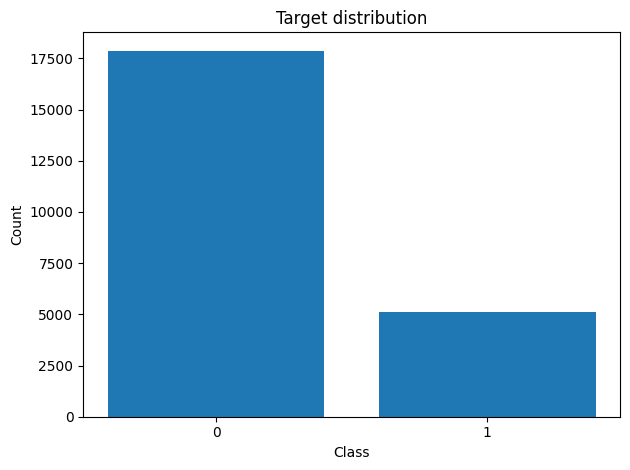

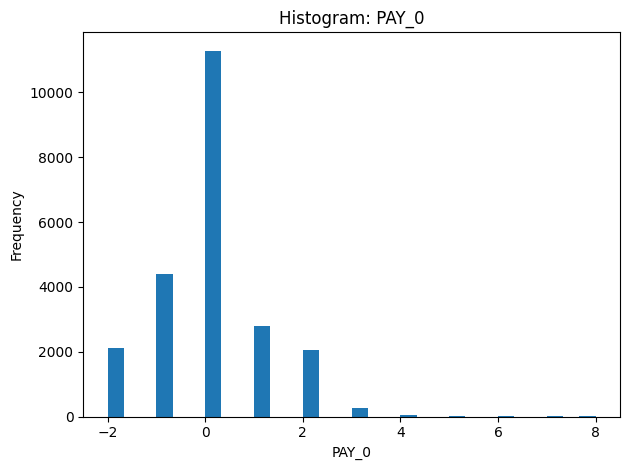

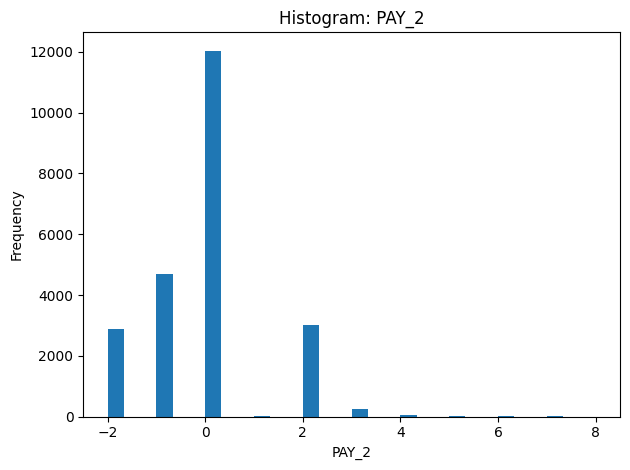

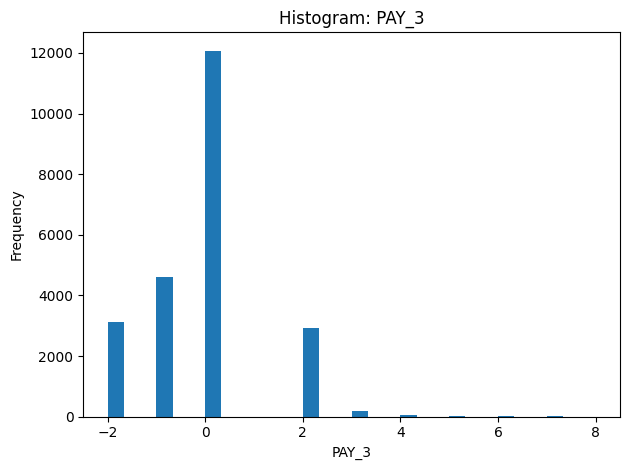

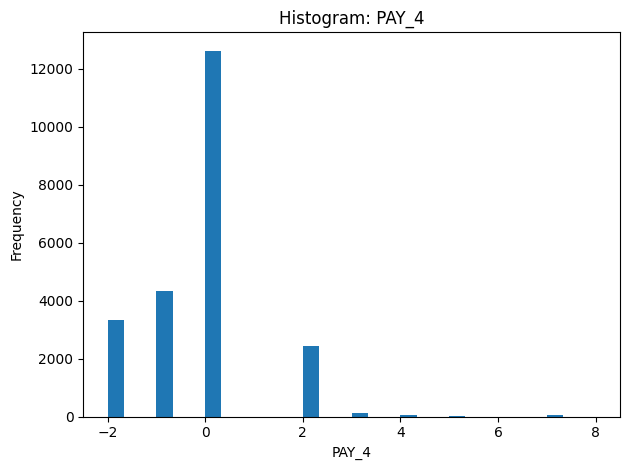

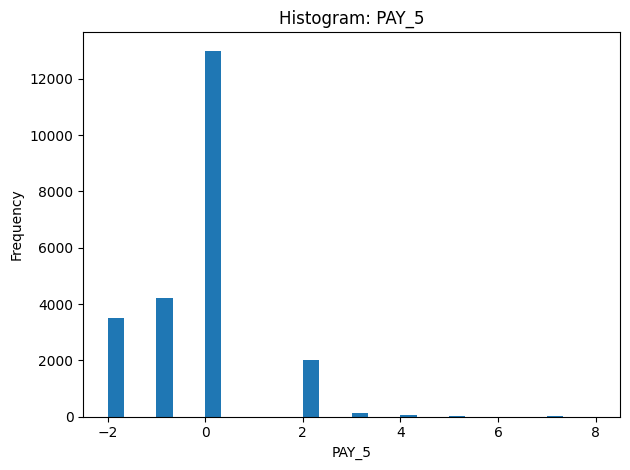

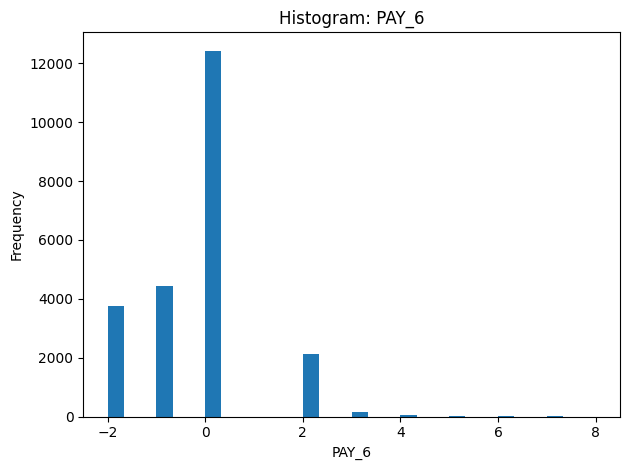

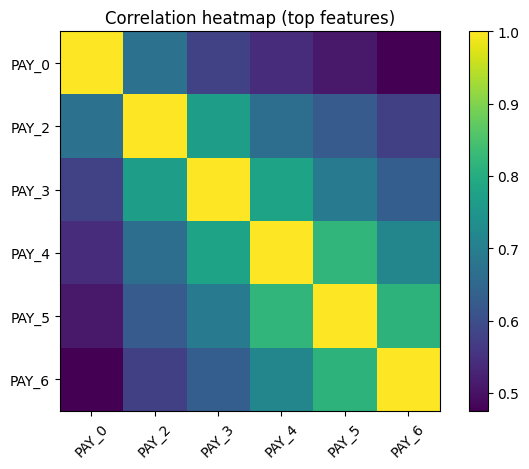

In [41]:
# ===================== EDA CELL 4: Plots =====================
# 1) Target bar
plt.figure()
vals = EDA_y.value_counts().sort_index()
plt.bar(vals.index.astype(str), vals.values)
plt.title("Target distribution")
plt.xlabel("Class"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

# 2) Histograms cho các feature quan trọng nhất theo |corr|
for col in EDA_top_feats[:6]:
    plt.figure()
    plt.hist(EDA_train[col].dropna().values, bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()

# (tuỳ chọn) Heatmap corr nhỏ cho 6 cột mạnh nhất
if len(EDA_top_feats) >= 3:
    plt.figure()
    m = EDA_train[EDA_top_feats].corr().values
    plt.imshow(m, interpolation="nearest")
    plt.xticks(range(len(EDA_top_feats)), EDA_top_feats, rotation=45)
    plt.yticks(range(len(EDA_top_feats)), EDA_top_feats)
    plt.title("Correlation heatmap (top features)")
    plt.colorbar(); plt.tight_layout(); plt.show()


🤖 Modeling

Cell 1/11 — Imports & Config

In [36]:
# Import các thư viện
import os, json, time, random
from datetime import datetime
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd

# Các công cụ từ Scikit-learn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Các thư viện Gradient Boosting (GBM)
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

# ===== Quick Config (edit these) =====
TRAIN_CSV = "./train.csv"            
TEST_CSV = "./test.csv"              
SAMPLE_SUB = "./sample_submission.csv"
OUTDIR = "./outputs"                
SEEDS = [42, 2021, 7, 99, 1234]      # Danh sách các seed để chạy nhiều lần
N_FOLDS = 10                         # Chia dữ liệu thành 10 phần

print("Missing libs (if any):", ", ".join(_MISSING_LIBS) or "None")
print("Paths:", TRAIN_CSV, TEST_CSV, SAMPLE_SUB)
print("Outdir:", OUTDIR)


Missing libs (if any): None
Paths: ./train.csv ./test.csv ./sample_submission.csv
Outdir: ./outputs


Cell 2/11 — Utilities

In [ ]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

def timestamp() -> str:
    return datetime.now().strftime("%Y%m%d-%H%M%S")

def auc(y_true, y_prob) -> float:
    return roc_auc_score(y_true, y_prob)

def safe_makedirs(path: str):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)


Cell 3/11 — Phân loại dữ liệu

In [ ]:
BILL_COLS = [f"BILL_AMT{i}" for i in range(1, 7)]
PAY_AMT_COLS = [f"PAY_AMT{i}" for i in range(1, 7)]
PAY_STATUS_COLS = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
CAT_COLS = ["SEX", "EDUCATION", "MARRIAGE"]
TARGET_COL = "default_payment_next_month"
ID_COL = "ID"


Cell 4/11 — FE Helpers (stats, slope, diffs)

In [ ]:
def _rowwise_stats(df: pd.DataFrame, cols: List[str], prefix: str) -> pd.DataFrame:
    X = df[cols].astype(float).values
    out = pd.DataFrame(index=df.index)
    out[f"{prefix}_sum"] = X.sum(axis=1)
    out[f"{prefix}_mean"] = X.mean(axis=1)
    out[f"{prefix}_std"] = X.std(axis=1)
    out[f"{prefix}_min"] = X.min(axis=1)
    out[f"{prefix}_max"] = X.max(axis=1)
    out[f"{prefix}_last"] = X[:, -1]
    return out

def _slope_over_time(df_vals: np.ndarray, x: np.ndarray) -> np.ndarray:
    xm = x.mean()
    denom = ((x - xm) ** 2).sum()
    y = df_vals
    ym = y.mean(axis=1, keepdims=True)
    num = ((x - xm) * (y - ym)).sum(axis=1)
    return num / (denom + 1e-9)

def _differences_stats(df_vals: np.ndarray, prefix: str) -> Dict[str, np.ndarray]:
    diffs = np.diff(df_vals, axis=1)
    return {
        f"{prefix}_diff_mean": diffs.mean(axis=1),
        f"{prefix}_diff_std": diffs.std(axis=1),
        f"{prefix}_diff_min": diffs.min(axis=1),
        f"{prefix}_diff_max": diffs.max(axis=1),
        f"{prefix}_diff_last": diffs[:, -1],
    }


Cell 5/11 — Hàm FE chính: add_safe_features

In [18]:
# ============================== CELL 5/11: add_safe_features() ==============================
"""Main FE function. Safe, row-wise, no leakage. Month-wise alignment for ratios/shortfalls."""

import re

def _get_months(df, prefix):
    # Lấy các cột có dạng PREFIX + số, ví dụ: BILL_AMT1..6
    months = []
    for c in df.columns:
        if c.startswith(prefix):
            m = re.search(r'(\d+)$', c)
            if m:
                months.append(int(m.group(1)))
    return sorted(set(months))

def add_safe_features(df: pd.DataFrame) -> pd.DataFrame:
    # Chuẩn hoá nhẹ đề phòng input bẩn
    df = df.copy()
    df.columns = df.columns.str.strip()
    df = df.loc[:, ~df.columns.duplicated()]
    
    out = pd.DataFrame(index=df.index)

    # Basic
    out["LIMIT_BAL_log"] = np.log1p(df["LIMIT_BAL"].astype(float))

    # Age (numeric + binned)
    age = df["AGE"].astype(float)
    out["AGE"] = age
    age_bins = pd.cut(age, bins=[0, 25, 35, 45, 55, 65, 100], labels=False, include_lowest=True)
    out["AGE_BIN"] = age_bins.fillna(-1).astype(int)

    # ===== Determine available months dynamically (robust to 6 or 12 months, etc.) =====
    bill_months = _get_months(df, "BILL_AMT")
    pay_months  = _get_months(df, "PAY_AMT")
    months      = [m for m in bill_months if m in pay_months]   # giao nhau để đảm bảo match
    if len(months) == 0:
        # fallback chuẩn 6 tháng
        months = [1,2,3,4,5,6]

    # Build aligned BILL and PAY frames with the same months
    bill_cols = [f"BILL_AMT{m}" for m in months]
    pay_cols  = [f"PAY_AMT{m}"  for m in months]

    bills = df[bill_cols].astype(float)
    limit = df["LIMIT_BAL"].astype(float).replace(0, np.nan)

    # Utilization: bill / limit
    util = bills.div(limit, axis=0).clip(0, 3.0).fillna(0.0)
    out = pd.concat([out, _rowwise_stats(util, util.columns.tolist(), "util")], axis=1)

    # Util slope with dynamic T
    T = util.shape[1]
    x_time = np.arange(1, T + 1, dtype=float)
    out["util_slope"] = _slope_over_time(util.values, x_time)

    # Bill dynamics (diffs) on aligned months
    bill_vals = bills.values
    for k, v in _differences_stats(bill_vals, "bill").items():
        out[k] = v

    # ===== Payment ratios: PAY_AMTt / (BILL_AMTt + eps) computed month-by-month =====
    eps = 1e-3
    pay_ratio = pd.DataFrame(index=df.index)
    for m in months:
        num = df[f"PAY_AMT{m}"].astype(float)
        den = df[f"BILL_AMT{m}"].astype(float).replace(0, np.nan)
        pay_ratio[f"payr_{m}"] = (num / (den + eps)).clip(0, 1.5).fillna(0.0)

    out = pd.concat([out, _rowwise_stats(pay_ratio, pay_ratio.columns.tolist(), "payr")], axis=1)
    out["payr_slope"] = _slope_over_time(pay_ratio.values, np.arange(1, len(months) + 1, dtype=float))

    # ===== Shortfall per month: BILL_AMTt - PAY_AMTt (aligned) =====
    shortfall = pd.DataFrame(index=df.index)
    for m in months:
        shortfall[f"short_{m}"] = (df[f"BILL_AMT{m}"].astype(float) - df[f"PAY_AMT{m}"].astype(float))
    out = pd.concat([out, _rowwise_stats(shortfall, shortfall.columns.tolist(), "short")], axis=1)

    # ===== PAY_* statuses (delinquency severity) =====
    # Lấy các cột PAY_* thực sự tồn tại, giữ thứ tự "gần nhất trước": PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6
    pay_status_order = [c for c in ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"] if c in df.columns]
    if len(pay_status_order) > 0:
        pays = df[pay_status_order].astype(float)
        pays_pos = pays.clip(lower=0)
        out["pay_recency"] = df["PAY_0"].astype(float) if "PAY_0" in df.columns else 0.0
        out["pay_max"]     = pays.max(axis=1)
        out["pay_sum_pos"] = (pays.values > 0).sum(axis=1)
        out["pay_days_sum"]= pays_pos.sum(axis=1)

        # Weighted by recency (most recent bigger weight)
        # Ví dụ có K cột -> weights = K, K-1, ..., 1
        K = len(pay_status_order)
        weights = np.arange(K, 0, -1, dtype=float)
        out["pay_wsum"] = (np.clip(pays.values, 0, None) * weights).sum(axis=1)
    else:
        out[["pay_recency","pay_max","pay_sum_pos","pay_days_sum","pay_wsum"]] = 0.0

    # Keep categorical raw
    for c in ["SEX", "EDUCATION", "MARRIAGE"]:
        if c in df.columns:
            out[c] = df[c].astype(int)
        else:
            out[c] = 0

    # Keep key originals (no data loss) — dùng aligned months cho BILL/PAY gốc
    keep_cols = ["LIMIT_BAL"] + bill_cols + pay_cols + [c for c in ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"] if c in df.columns]
    out = pd.concat([out, df[keep_cols].astype(float)], axis=1)

    return out.replace([np.inf, -np.inf], np.nan).fillna(0.0)


Cell 6/11 — Load data + FE + matrix hoá

In [22]:
# ============================== CELL 6/11 (patched, NO FLOAT DOWNCAST): Load Data & Build FE ==============================
"""Load CSVs, build FE, keep DataFrame end-to-end. No float downcast; only ensure categorical as ints for CatBoost."""

start_time = time.time()
safe_makedirs(OUTDIR)

train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)

assert TARGET_COL in train.columns, f"Missing target '{TARGET_COL}' in train.csv"
assert ID_COL in train.columns and ID_COL in test.columns, "Missing ID column"

y = train[TARGET_COL].astype(int).values
train_ids = train[ID_COL].values
test_ids  = test[ID_COL].values

print("Building features…")
train_fe = add_safe_features(train)
test_fe  = add_safe_features(test)

# Đảm bảo test có đủ & đúng thứ tự cột như train
assert set(train_fe.columns) == set(test_fe.columns), "Train/Test feature sets differ!"
test_fe = test_fe[train_fe.columns]

# Khai báo categorical theo tên (LightGBM dùng tên; CatBoost dùng index)
# Nếu dự án mày có set khác, sửa list dưới cho đúng:
cat_cols = [c for c in ["SEX", "EDUCATION", "MARRIAGE", "AGE_BIN"] if c in train_fe.columns]

# Chỉ ép categorical về int (giữ nguyên float dtypes cho số liệu khác)
for c in cat_cols:
    train_fe[c] = train_fe[c].astype("int64")
    test_fe[c]  = test_fe[c].astype("int64")

# GIỮ DataFrame, KHÔNG .values
X_df      = train_fe.copy()
X_test_df = test_fe.copy()

# CatBoost cần index vị trí cột categorical
cat_idx = [X_df.columns.get_loc(c) for c in cat_cols]

# Safety checks kiểu "reviewer khó tính"
assert list(X_df.columns) == list(X_test_df.columns), "Tên/thứ tự cột giữa train/test KHÔNG khớp."
for c in cat_cols:
    assert pd.api.types.is_integer_dtype(X_df[c]), f"Categorical '{c}' phải là int"

print(f"Feature dim: {X_df.shape[1]} | Train: {X_df.shape[0]} | Test: {X_test_df.shape[0]}")
print(f"Categorical cols: {cat_cols}")


Building features…
Feature dim: 55 | Train: 23000 | Test: 7000
Categorical cols: ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE_BIN']


Cell 7/11 — Train LightGBM

In [23]:
# ============================== CELL 7/11 (patched): Train LightGBM ==============================
"""Train LGBM with DataFrame + categorical by name (no float downcast)."""

oof_store, test_store, auc_store = {}, {}, {}

if lgb is None:
    print("[LGB] Skipped (library not installed). pip install -U lightgbm")
else:
    lgb_oofs, lgb_tests, lgb_aucs = [], [], []
    for sd in SEEDS:
        set_seed(sd)
        params = dict(
            objective="binary",
            learning_rate=0.05,
            num_leaves=31,
            max_depth=-1,
            min_data_in_leaf=60,
            feature_fraction=0.9,
            bagging_fraction=0.9,
            bagging_freq=1,
            lambda_l1=0.0,
            lambda_l2=10.0,
            metric="auc",
            n_estimators=2000,
            random_state=sd,
            verbose=-1,
        )
        skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=sd)
        oof_pred = np.zeros(len(X_df), dtype=np.float64)
        tst_pred = np.zeros(len(X_test_df), dtype=np.float64)

        for fold, (trn_idx, val_idx) in enumerate(skf.split(X_df, y), 1):
            X_tr, y_tr = X_df.iloc[trn_idx], y[trn_idx]
            X_va, y_va = X_df.iloc[val_idx], y[val_idx]

            model = lgb.LGBMClassifier(**params)
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                eval_metric="auc",
                categorical_feature=cat_cols,  # by NAME
                callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)],
            )
            oof_pred[val_idx] = model.predict_proba(X_va)[:, 1]
            tst_pred += model.predict_proba(X_test_df)[:, 1] / N_FOLDS

        lgb_oofs.append(oof_pred)
        lgb_tests.append(tst_pred)
        lgb_auc = auc(y, oof_pred)
        lgb_aucs.append(lgb_auc)
        print(f"[LGB][seed {sd}] OOF AUC = {lgb_auc:.6f}")

    oof_store["lgb"] = np.vstack(lgb_oofs).mean(axis=0)
    test_store["lgb"] = np.vstack(lgb_tests).mean(axis=0)
    auc_store["lgb_mean_auc"] = float(np.mean(lgb_aucs))


[LGB][seed 42] OOF AUC = 0.787201
[LGB][seed 2021] OOF AUC = 0.783149
[LGB][seed 7] OOF AUC = 0.785245
[LGB][seed 99] OOF AUC = 0.781153
[LGB][seed 1234] OOF AUC = 0.784869


Cell 8/11 — Train XGBoost

In [27]:
# ============================== CELL 8/11 (patched): Train XGBoost via xgb.train + DMatrix ==============================
"""XGBoost: dùng low-level API (xgb.train) để tương thích mọi version; có early stopping ổn định.
Giữ DataFrame end-to-end; KHÔNG downcast float."""

if xgb is None:
    print("[XGB] Skipped (library not installed). pip install -U xgboost")
else:
    xgb_oofs, xgb_tests, xgb_aucs = [], [], []
    neg, pos = (y == 0).sum(), (y == 1).sum()
    spw = neg / max(pos, 1)

    # Tham số cho xgb.train (tên param theo dạng native)
    base_params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "eta": 0.05,
        "max_depth": 4,
        "min_child_weight": 5,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "reg_lambda": 2.0,
        "tree_method": "hist",
        "scale_pos_weight": spw,
        "nthread": -1,      # dùng tất cả CPU
    }

    # Reuse DMatrix cho test để nhanh hơn
    dtest_global = xgb.DMatrix(X_test_df)

    for sd in SEEDS:
        params = dict(base_params)
        params["seed"] = sd

        skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=sd)
        oof_pred = np.zeros(len(X_df), dtype=np.float64)
        tst_pred = np.zeros(len(X_test_df), dtype=np.float64)

        for fold, (trn_idx, val_idx) in enumerate(skf.split(X_df, y), 1):
            X_tr, y_tr = X_df.iloc[trn_idx], y[trn_idx]
            X_va, y_va = X_df.iloc[val_idx], y[val_idx]

            dtr = xgb.DMatrix(X_tr, label=y_tr)
            dva = xgb.DMatrix(X_va, label=y_va)

            booster = xgb.train(
                params=params,
                dtrain=dtr,
                num_boost_round=5000,
                evals=[(dva, "valid")],
                early_stopping_rounds=200,
                verbose_eval=False,   # nếu muốn xem log, đổi thành 100 hay True
            )

            # Dự đoán dùng best_iteration (tương thích nhiều version)
            try:
                val_pred = booster.predict(dva, iteration_range=(0, booster.best_iteration + 1))
                test_pred = booster.predict(dtest_global, iteration_range=(0, booster.best_iteration + 1))
            except Exception:
                ntree = getattr(booster, "best_ntree_limit", None)
                if ntree is None:
                    ntree = getattr(booster, "best_iteration", 0) + 1
                val_pred = booster.predict(dva, ntree_limit=ntree)
                test_pred = booster.predict(dtest_global, ntree_limit=ntree)

            oof_pred[val_idx] = val_pred
            tst_pred += test_pred / N_FOLDS

        xgb_oofs.append(oof_pred)
        xgb_tests.append(tst_pred)
        xgb_auc = auc(y, oof_pred)
        xgb_aucs.append(xgb_auc)
        print(f"[XGB][seed {sd}] OOF AUC = {xgb_auc:.6f}")

    oof_store["xgb"] = np.vstack(xgb_oofs).mean(axis=0)
    test_store["xgb"] = np.vstack(xgb_tests).mean(axis=0)
    auc_store["xgb_mean_auc"] = float(np.mean(xgb_aucs))


[XGB][seed 42] OOF AUC = 0.790678
[XGB][seed 2021] OOF AUC = 0.789370
[XGB][seed 7] OOF AUC = 0.789042
[XGB][seed 99] OOF AUC = 0.788457
[XGB][seed 1234] OOF AUC = 0.788073


🔁 Thay CELL 9/11: Train CatBoost (cat_features bằng index, no float downcast)


In [28]:
# ============================== CELL 9/11 (patched): Train CatBoost ==============================
"""Train CAT using Pool with cat_features by index; keep numeric floats as-is."""

if CatBoostClassifier is None:
    print("[CAT] Skipped (library not installed). pip install -U catboost")
else:
    cat_oofs, cat_tests, cat_aucs = [], [], []
    for sd in SEEDS:
        set_seed(sd)
        params = dict(
            loss_function="Logloss",
            eval_metric="AUC",
            depth=6,
            learning_rate=0.05,
            l2_leaf_reg=5.0,
            random_seed=sd,
            iterations=3000,
            od_type="Iter",
            od_wait=300,
            task_type="CPU",
            verbose=False,
        )

        skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=sd)
        oof_pred = np.zeros(len(X_df), dtype=np.float64)
        tst_pred = np.zeros(len(X_test_df), dtype=np.float64)

        for fold, (trn_idx, val_idx) in enumerate(skf.split(X_df, y), 1):
            X_tr, y_tr = X_df.iloc[trn_idx], y[trn_idx]
            X_va, y_va = X_df.iloc[val_idx], y[val_idx]

            train_pool = Pool(X_tr, y_tr, cat_features=cat_idx if len(cat_idx) else None)
            valid_pool = Pool(X_va, y_va, cat_features=cat_idx if len(cat_idx) else None)

            model = CatBoostClassifier(**params)
            model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

            oof_pred[val_idx] = model.predict_proba(valid_pool)[:, 1]
            tst_pred += model.predict_proba(Pool(X_test_df, cat_features=cat_idx if len(cat_idx) else None))[:, 1] / N_FOLDS

        cat_oofs.append(oof_pred)
        cat_tests.append(tst_pred)
        cat_auc = auc(y, oof_pred)
        cat_aucs.append(cat_auc)
        print(f"[CAT][seed {sd}] OOF AUC = {cat_auc:.6f}")

    oof_store["cat"] = np.vstack(cat_oofs).mean(axis=0)
    test_store["cat"] = np.vstack(cat_tests).mean(axis=0)
    auc_store["cat_mean_auc"] = float(np.mean(cat_aucs))


[CAT][seed 42] OOF AUC = 0.792105
[CAT][seed 2021] OOF AUC = 0.790292
[CAT][seed 7] OOF AUC = 0.791919
[CAT][seed 99] OOF AUC = 0.791423
[CAT][seed 1234] OOF AUC = 0.791576


Cell 10/11 — Ensemble (rank-avg) + Stacking (Logistic) + Diagnostics

In [29]:
# ============================== CELL 10/11: Ensemble, Stack, Diagnostics ==============================
"""Rank-averaging + simple logistic stacker for robustness. You may turn off stacker if you want."""

def rank_normalize(a: np.ndarray) -> np.ndarray:
    s = pd.Series(a)
    r = s.rank(method='average')
    return ((r - 1) / (len(s) - 1)).values

# Sanity: must have at least one base model
assert len(test_store) > 0, "No base model trained. Install missing libs or check earlier cells."

base_keys = list(test_store.keys())
oof_base = np.vstack([oof_store[k] for k in base_keys]).T
TST_base = np.vstack([test_store[k] for k in base_keys]).T

# Rank-average ensemble
oof_rank = np.mean(np.column_stack([rank_normalize(oof_base[:, i]) for i in range(oof_base.shape[1])]), axis=1)
tst_rank = np.mean(np.column_stack([rank_normalize(TST_base[:, i]) for i in range(TST_base.shape[1])]), axis=1)
auc_rank = auc(y, oof_rank)
print(f"[Ensemble][RankAvg] OOF AUC = {auc_rank:.6f}")

# Simple stacker on base OOF
scaler = StandardScaler()
X_meta = scaler.fit_transform(oof_base)
meta_clf = LogisticRegression(max_iter=2000)
meta_clf.fit(X_meta, y)
oof_stack = meta_clf.predict_proba(X_meta)[:, 1]
tst_stack = meta_clf.predict_proba(scaler.transform(TST_base))[:, 1]
auc_stack = auc(y, oof_stack)
print(f"[Stack][LR] OOF AUC = {auc_stack:.6f}")

# Final blend: rank-average over (base models + stacker)
oof_all = np.column_stack([oof_base, oof_stack])
tst_all = np.column_stack([TST_base, tst_stack])
oof_final = np.mean(np.column_stack([rank_normalize(oof_all[:, i]) for i in range(oof_all.shape[1])]), axis=1)
tst_final = np.mean(np.column_stack([rank_normalize(tst_all[:, i]) for i in range(tst_all.shape[1])]), axis=1)
auc_final = auc(y, oof_final)
print(f"[FINAL][RankAvg(base+stack)] OOF AUC = {auc_final:.6f}")


[Ensemble][RankAvg] OOF AUC = 0.792295
[Stack][LR] OOF AUC = 0.792354
[FINAL][RankAvg(base+stack)] OOF AUC = 0.792432


Cell 11/11 — Lưu submission + OOF + meta

In [30]:
# ============================== CELL 11/11: Save Submission & Artifacts ==============================
"""Writes submission CSV, OOF diagnostics, and run metadata JSON into OUTDIR."""

meta = {
    "time": timestamp(),
    "seeds": SEEDS,
    "base_models": list(test_store.keys()),
    "auc": {**auc_store, "ensemble_rank": float(auc_rank), "stack_lr": float(auc_stack), "final_rank": float(auc_final)},
    "train_rows": int(X.shape[0]),
    "test_rows": int(X_test.shape[0]),
    "n_features": int(X.shape[1]),
    "features": fe_cols,
}

safe_makedirs(OUTDIR)
with open(os.path.join(OUTDIR, f"run_meta_{timestamp()}.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

# Submission file (Kaggle format)
sub = pd.DataFrame({
    "ID": test_ids,
    "default_payment_next_month": tst_final.astype(float),
})
sub_path = os.path.join(OUTDIR, f"submission_{timestamp()}.csv")
sub.sort_values("ID").to_csv(sub_path, index=False)
print(f"[OK] Submission saved to: {sub_path}")

# OOF diagnostics (help you inspect blend stability)
oof_df = pd.DataFrame({
    "ID": train_ids,
    "y": y,
    **{f"oof_{k}": oof_store[k] for k in base_keys},
    "oof_rank": oof_rank,
    "oof_stack": oof_stack,
    "oof_final": oof_final,
})
oof_path = os.path.join(OUTDIR, f"oof_{timestamp()}.csv")
oof_df.to_csv(oof_path, index=False)
print(f"[OK] OOF diagnostics saved to: {oof_path}")

print(f"Done in {(time.time()-start_time)/60:.2f} min")


[OK] Submission saved to: ./outputs\submission_20250826-155148.csv
[OK] OOF diagnostics saved to: ./outputs\oof_20250826-155148.csv
Done in 33.85 min


🔵 CELL A — ROC curves (so sánh OOF các model & ensemble)

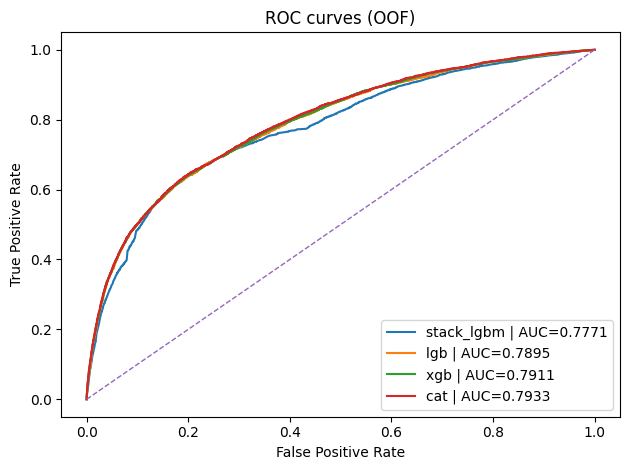

In [42]:
# ===================== DIAG CELL A: ROC curves (OOF) =====================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

assert 'oof_store' in globals(), "Không thấy oof_store. Hãy chạy xong phần train trước."
assert 'y' in globals(), "Không thấy biến y (target)."

# Chọn các key để vẽ: 3 base + (nếu có) ensemble
base_keys = [k for k in oof_store.keys() if k.lower().startswith(('lgb', 'xgb', 'cat'))]
ens_keys  = [k for k in oof_store.keys() if any(t in k.lower() for t in ['final','blend','rank','stack','ens'])]

plot_keys = []
# Ưu tiên ensemble đầu tiên (nếu có)
if ens_keys:
    # lấy key ensemble có AUC cao nhất
    best_ens = max(ens_keys, key=lambda k: roc_auc_score(y, oof_store[k]))
    plot_keys.append(best_ens)
# thêm 3 base (nếu có)
for fam in ['lgb','xgb','cat']:
    kfam = [k for k in base_keys if k.lower().startswith(fam)]
    if kfam:
        # nếu có nhiều phiên bản, lấy AUC cao nhất trong fam
        best = max(kfam, key=lambda k: roc_auc_score(y, oof_store[k]))
        plot_keys.append(best)

# Nếu chưa có gì (case hiếm), vẽ tất cả
if not plot_keys:
    plot_keys = list(oof_store.keys())

plt.figure()
for k in plot_keys:
    fpr, tpr, _ = roc_curve(y, oof_store[k])
    auc = roc_auc_score(y, oof_store[k])
    plt.plot(fpr, tpr, label=f"{k} | AUC={auc:.4f}")

plt.plot([0,1], [0,1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curves (OOF)")
plt.legend()
plt.tight_layout()
plt.show()


🔵 CELL B — Phân phối xác suất (OOF) cho ensemble (hoặc model tốt nhất)

Dùng model để vẽ distribution: cat (AUC=0.793291)


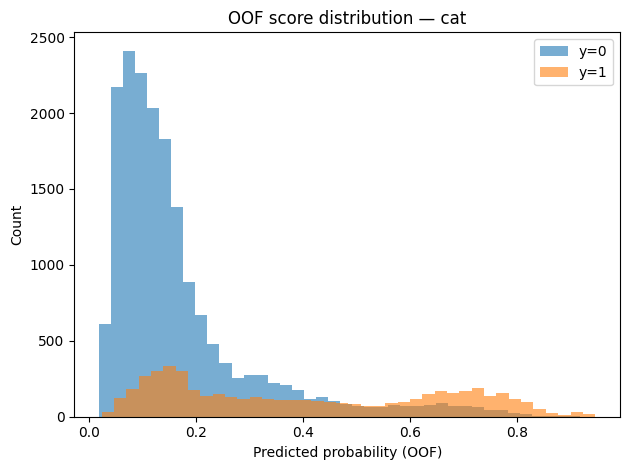

In [43]:
# ===================== DIAG CELL B: OOF score distributions =====================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

assert 'oof_store' in globals() and 'y' in globals()

# Ưu tiên dùng ensemble nếu có, nếu không dùng model AUC cao nhất
cand_keys = list(oof_store.keys())
best_key = max(cand_keys, key=lambda k: roc_auc_score(y, oof_store[k]))
best_auc = roc_auc_score(y, oof_store[best_key])
print(f"Dùng model để vẽ distribution: {best_key} (AUC={best_auc:.6f})")

p = oof_store[best_key]
neg = p[y == 0]; pos = p[y == 1]

bins = 40
plt.figure()
plt.hist(neg, bins=bins, alpha=0.6, label="y=0")
plt.hist(pos, bins=bins, alpha=0.6, label="y=1")
plt.xlabel("Predicted probability (OOF)"); plt.ylabel("Count")
plt.title(f"OOF score distribution — {best_key}")
plt.legend()
plt.tight_layout()
plt.show()


🔵 CELL C — Ma trận tương quan giữa OOF của các model

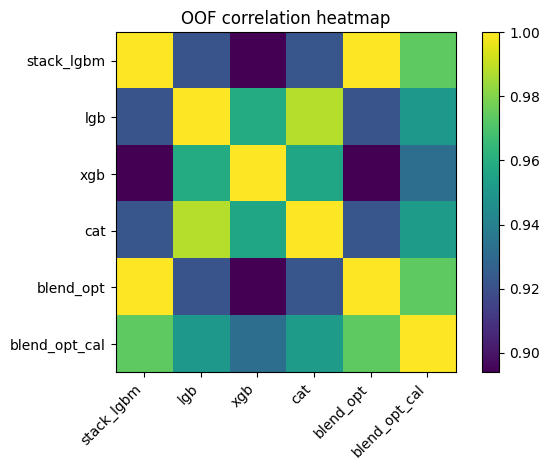

In [44]:
# ===================== DIAG CELL C: OOF correlation heatmap =====================
import numpy as np
import matplotlib.pyplot as plt

assert 'oof_store' in globals()

# Lấy tối đa 6 đại diện: ensemble tốt nhất + 3 base (mỗi fam 1 model tốt nhất) + thêm 2 model phụ nếu có
names = []
data = []

# 1) Ensemble (nếu có)
ens_keys = [k for k in oof_store if any(t in k.lower() for t in ['final','blend','rank','stack','ens'])]
if ens_keys:
    best_ens = max(ens_keys, key=lambda k: roc_auc_score(y, oof_store[k]))
    names.append(best_ens); data.append(oof_store[best_ens])

# 2) Mỗi family 1 model tốt nhất
for fam in ['lgb','xgb','cat']:
    fam_keys = [k for k in oof_store if k.lower().startswith(fam)]
    if fam_keys:
        best = max(fam_keys, key=lambda k: roc_auc_score(y, oof_store[k]))
        names.append(best); data.append(oof_store[best])

# 3) Thêm phụ (nếu còn)
extra = [k for k in oof_store if k not in names]
for k in extra[:2]:
    names.append(k); data.append(oof_store[k])

if len(names) < 2:
    print("Không đủ model để vẽ correlation heatmap.")
else:
    mat = np.column_stack(data)
    corr = np.corrcoef(mat.T)

    plt.figure()
    plt.imshow(corr, interpolation="nearest")
    plt.xticks(range(len(names)), names, rotation=45, ha='right')
    plt.yticks(range(len(names)), names)
    plt.title("OOF correlation heatmap")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


🔵 CELL D (tuỳ chọn) — Feature importance (Top-20)

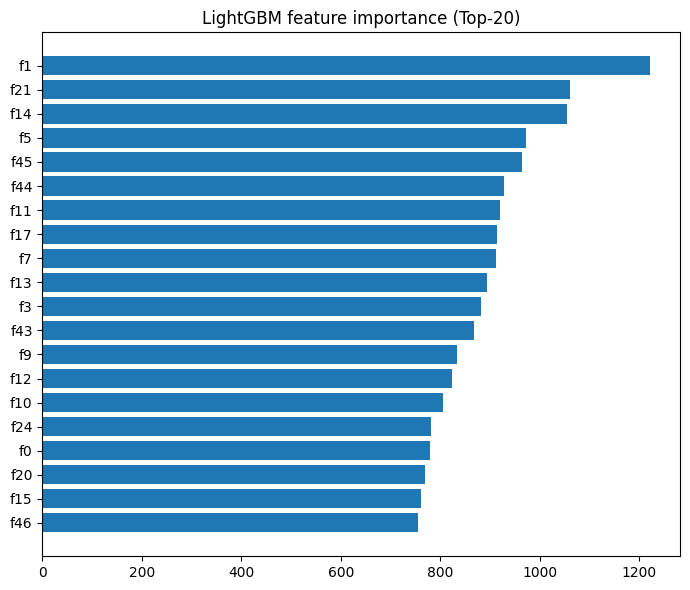

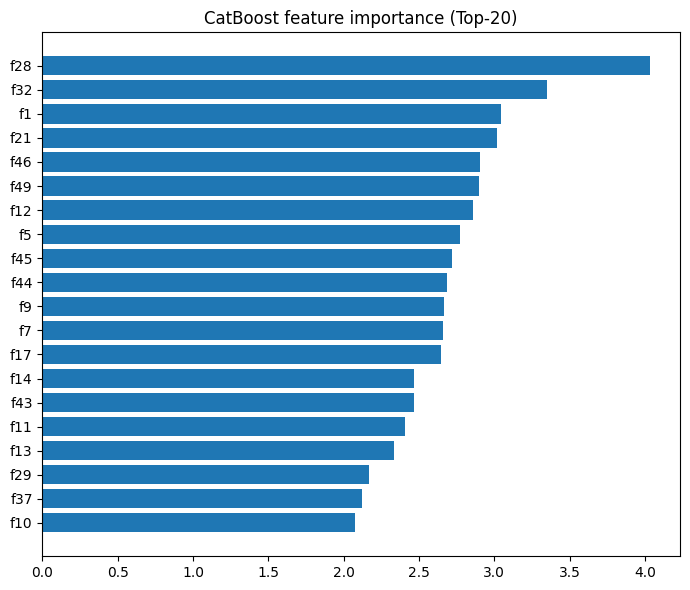

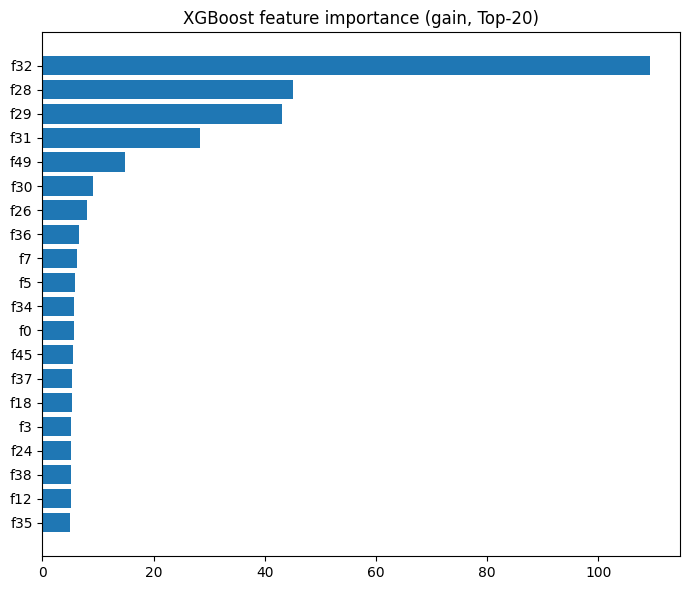

In [46]:
# ===================== DIAG CELL D (fixed): Feature importance (Top-20) =====================
import numpy as np
import matplotlib.pyplot as plt

# Cần: X, y đã có từ phần train; nếu không có feature_cols thì tự suy ra
assert 'X' in globals() and 'y' in globals(), "Cần X, y từ phần train."

# Chuẩn hoá X thành DataFrame + lấy tên cột
try:
    import pandas as pd
except Exception:
    pd = None

def make_X_df_and_names(X):
    if pd is not None and hasattr(X, "columns"):
        # X là DataFrame
        feat_names = list(X.columns)
        return X, feat_names
    else:
        # X là ndarray; cố gắng dùng feature_cols nếu có, không thì tự tạo tên f0..fN
        if 'feature_cols' in globals() and isinstance(feature_cols, (list, tuple)) and len(feature_cols) == X.shape[1]:
            feat_names = list(feature_cols)
        else:
            feat_names = [f"f{i}" for i in range(X.shape[1])]
        if pd is not None:
            X_df = pd.DataFrame(X, columns=feat_names)
        else:
            # Không có pandas thì vẫn trả về ndarray & list tên (plot vẫn chạy được)
            X_df = X
        return X_df, feat_names

X_df, feat_names = make_X_df_and_names(X)

def plot_top20(names, imps, title):
    imps = np.asarray(imps)
    order = np.argsort(imps)[::-1][:20]
    plt.figure(figsize=(7,6))
    plt.barh(np.array(names)[order][::-1], imps[order][::-1])
    plt.title(title)
    plt.tight_layout()
    plt.show()

plotted_any = False

# ---- LightGBM importance
try:
    import lightgbm as lgb
    m_lgb = lgb.LGBMClassifier(
        objective="binary",
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=123,
        n_jobs=-1
    )
    m_lgb.fit(X_df, y)
    imp_lgb = getattr(m_lgb, "feature_importances_", None)
    if imp_lgb is not None and len(imp_lgb) == len(feat_names):
        plot_top20(feat_names, imp_lgb, "LightGBM feature importance (Top-20)")
        plotted_any = True
except Exception as e:
    print("[Note] Bỏ qua LGBM importance:", e)

# ---- CatBoost importance
try:
    from catboost import CatBoostClassifier
    m_cat = CatBoostClassifier(
        iterations=1000, learning_rate=0.03, depth=6,
        loss_function="Logloss", eval_metric="AUC",
        verbose=False, random_seed=123
    )
    m_cat.fit(X_df, y)
    imp_cat = m_cat.get_feature_importance()
    if imp_cat is not None and len(imp_cat) == len(feat_names):
        plot_top20(feat_names, imp_cat, "CatBoost feature importance (Top-20)")
        plotted_any = True
except Exception as e:
    print("[Note] Bỏ qua CatBoost importance:", e)

# (tuỳ chọn) XGBoost importance (nếu muốn thêm)
try:
    import xgboost as xgb
    m_xgb = xgb.XGBClassifier(
        objective="binary:logistic", eval_metric="auc",
        n_estimators=800, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, min_child_weight=5,
        tree_method="hist", random_state=123
    )
    m_xgb.fit(X_df, y)
    # lấy gain importance
    booster = m_xgb.get_booster()
    fmap = {i: n for i, n in enumerate(feat_names)}
    # map importance về đúng thứ tự cột
    score = booster.get_score(importance_type='gain')
    imp_xgb = np.zeros(len(feat_names), dtype=float)
    for k, v in score.items():
        # k như 'f0','f1',...
        try:
            idx = int(k[1:])
            imp_xgb[idx] = float(v)
        except Exception:
            pass
    if imp_xgb.sum() > 0:
        plot_top20(feat_names, imp_xgb, "XGBoost feature importance (gain, Top-20)")
        plotted_any = True
except Exception as e:
    print("[Note] Bỏ qua XGBoost importance:", e)

if not plotted_any:
    print("Không vẽ được importance (thiếu lib hoặc không khớp tên cột). Bỏ qua cell này cũng không ảnh hưởng.")
